In [1]:
#userid,songid,playcounts-哥伦比亚大学的数据库
import pandas as pd
import numpy as np
import time
import sqlite3

import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [7]:
triplet_dataset = pd.read_csv(filepath_or_buffer='./data/train_triplets.txt',
                              nrows=10000,sep='\t',header=None,
                             names=['user','song','play_count'])

In [8]:
triplet_dataset.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [10]:
#时间较长_用户播放排名
# 20%的用户占了80%的总体播放量，82定律，直接用pandas里的方法可能会出错
output_dict={}
with open('./data/train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        user = line.split('\t')[0]
        play_count = int(line.split('\t')[2])
        if user in output_dict:
            play_count += output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
play_count_df = pd.DataFrame(output_list)
play_count_df = play_count_df.sort_values(by = 'play_count',ascending = False)#降序排列

play_count_df.to_csv(path_or_buf='./data/user_playcount_df.csv',index = False)

In [20]:
play_count_df=pd.read_csv('./data/user_playcount_df.csv')
play_count_df.head()

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04


In [18]:
output_dict={}
with open('./data/train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        song = line.split('\t')[1]
        play_count = int(line.split('\t')[2])
        if song in output_dict:
            play_count += output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
song_count_df = pd.DataFrame(output_list)
song_count_df = song_count_df.sort_values(by = 'play_count',ascending = False)#降序排列

song_count_df.to_csv(path_or_buf='./data/song_playcount_df.csv',index = False)

In [16]:
song_count_df=pd.read_csv('./data/song_playcount_df.csv')
song_count_df.head()

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3


In [41]:
#找到前多少用户占了四成的播放量，这个四成自己定，这里大约是前100000的用户，购物网站的话应该要再高一点这个值
total_play_count = sum(song_count_df.play_count)
print(float(play_count_df.head(100000).play_count.sum())/total_play_count)*100

play_count_subset = play_count_df.head(n=100000)

40.8807280501


In [42]:
print(float(song_count_df.head(30000).play_count.sum())/total_play_count)*100
#前30000首占了78%的播放量
song_count_subset = song_count_df.head(n=30000)

78.3931536665


In [43]:
user_subset=list(play_count_subset.user)#前100000用户与30000歌曲名单
song_subset=list(song_count_subset.song)

In [33]:
triplet_dataset = pd.read_csv(filepath_or_buffer='./data/train_triplets.txt',sep='\t',
                              header=None,names=['user','song','play_count'])

In [36]:
#抽取这些目标用户的原始数据
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset)]
del(triplet_dataset)#内存释放

In [38]:
#再除去其中非排名前30000的歌曲
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
del(triplet_dataset_sub)

In [39]:
triplet_dataset_sub_song.to_csv('./data/triplets_dataset_sub_song.csv',index=False)

In [40]:
triplet_dataset_sub_song.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10775230 entries, 498 to 48373494
Data columns (total 3 columns):
user          object
song          object
play_count    int64
dtypes: int64(1), object(2)
memory usage: 328.8+ MB


In [44]:
#加载数据库
conn = sqlite3.connect('./data/track_metadata.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[(u'songs',)]

In [45]:
track_metadata_df = pd.read_sql(con=conn,sql='SELECT * FROM songs')
track_metadata_df_sub = track_metadata_df[track_metadata_df.song_id.isin(song_subset)]

In [46]:
track_metadata_df_sub.shape

(30447, 14)

In [47]:
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
115,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
123,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
172,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
191,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


In [48]:
#merge
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])
track_metadata_df_sub = track_metadata_df_sub.drop_duplicates(['song_id'])
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song,track_metadata_df_sub,how='left',left_on='song',right_on='song_id')
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

In [53]:
#删除无用字段
# del(triplet_dataset_sub_song_merged['song_id'])
# del(triplet_dataset_sub_song_merged['artist_id'])
# del(triplet_dataset_sub_song_merged['duration'])
# del(triplet_dataset_sub_song_merged['artist_familiarity'])
# del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
# del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

In [54]:
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [55]:
triplet_dataset_sub_song_merged.to_csv('./data/triplet_dataset_sub_song_merged.csv',encoding='utf-8',index=False)

In [56]:
#每个用户听过多少首不同的歌
user_song_count_distribution = triplet_dataset_sub_song_merged[['user','title']].groupby('user').count(
).reset_index().sort_values(by='title',ascending=False)
user_song_count_distribution.title.describe()#平均值，众数，最大最小值等等

count    99996.000000
mean       107.756610
std         79.739193
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

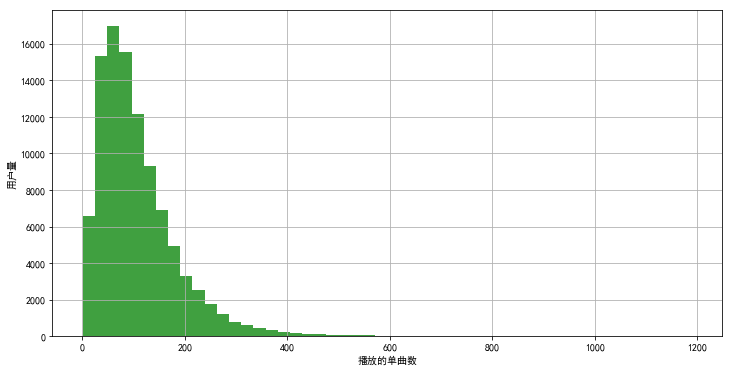

In [61]:
x = user_song_count_distribution.title
plt.figure(figsize=(12,6))
n,bins,patches=plt.hist(x,50,facecolor="g",alpha=0.75)
plt.xlabel(u'播放的单曲数')
plt.ylabel(u'用户量')
plt.grid(True)

基于用户的推荐引擎，用户为最重要的实体，它的基本逻辑是寻找用户间的相似性，然后以此作为推荐的基础
基于内容的推荐引擎，内容为最重要的实体，比如在这个案例中，歌曲就是核心。这种算法会寻找内容的特征，然后建立内容间的
相似性，基于这些相似性再做推荐
混合推荐引擎，这种也被称为协同过滤。
https://github.com/llSourcell

基于热度的推荐引擎
如果一样东西被很多人喜欢，那么把它推荐给更多的人效果应该也不会太差

In [62]:
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(triplet_dataset_sub_song_merged,test_size=0.4,random_state=42)
train_data.head()

,user,song,listen_count,title,release,artist_name,year
4144944,9488bcaa75fb7c209d0e2eb73fa37ae3e5b28604,SONZSJY12A6D4FE023,2,My Isolation,Pretend Or Surrender,Lovex,2008
3822299,e30541193c23b565e25eef8f85d231b0a79d87a2,SOEMWQB12A8C14240A,2,Wishbone,In Case We Die,Architecture In Helsinki,2005
3345491,79cc03393b8bd7d97390677b1c8d5a64b71d208b,SOZFHVL12AB0182D22,2,You Told A Lie,My Maudlin Career,Camera Obscura,0
6165678,b85b23afea422f2d8fb8d6a860d912f8e4ea2dbe,SOIKTRP12A81C219C9,1,Na Na Na,Silent Shout,The Knife,0
2002467,462bcfaf52f30c4964ba7e0f133a9d8dfb0e4863,SORCMHW12A6D4F756B,4,MakeDamnSure (Album Version),Louder Now,Taking Back Sunday,2006


In [65]:
#基于热度的推荐
def create_popularity_recommendation(train_data,user_id,item_id):
    train_data_grouped = train_data.groupby([item_id]).agg({user_id:'count'}).reset_index()
    train_data_grouped.rename(columns={user_id:'score'},inplace=True)
    
    train_data_sort = train_data_grouped.sort_values(['score',item_id],ascending=[0,1])
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0,method='first')
    popularity_recommendations = train_data_sort.head(20)#推荐前20
    return popularity_recommendations

In [66]:
recommendations = create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')
recommendations

,title,score,Rank
19581,Sehr kosmisch,18628,1.0
5782,Dog Days Are Over (Radio Edit),17638,2.0
27315,You're The One,16083,3.0
19543,Secrets,15136,4.0
18637,Revelry,14943,5.0
25071,Undo,14681,6.0
7532,Fireflies,13084,7.0
9642,Hey_ Soul Sister,12996,8.0
25217,Use Somebody,12791,9.0
9923,Horn Concerto No. 4 in E flat K495: II. Romanc...,12343,10.0


基于内容的推荐系统
第i首歌与第j首歌的相似度计算——两首歌听众的交集除以两首歌听众的并集。以用户的重复程度表达内容的相似度

1.找出该用户听过的歌曲
2.针对他听过的每首歌计算一下所有歌曲的相似度，n^2 ———缩减曲库
3.以相似度为准，找出相似度最高的歌曲并向用户推荐

In [67]:
song_count_subset = song_count_df.head(n=5000)
user_subset = list(play_count_subset.user)
song_subset = list(song_count_subset.song)
triplet_dataset_sub_song_merged_sub = triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [68]:
triplet_dataset_sub_song_merged_sub.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [69]:
train_data,test_data = train_test_split(triplet_dataset_sub_song_merged_sub, test_size = 0.3, random_state=0)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data,'user','title')

In [71]:
#向用户6推荐，时间半个小时
user_id = list(train_data.user)[6]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 43
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :191688


,user_id,song,score,rank
0,121c6a5ef04e00fc147f424d625b815cac62c551,Songs Of The Season,0.031755,1
1,121c6a5ef04e00fc147f424d625b815cac62c551,Mia,0.030257,2
2,121c6a5ef04e00fc147f424d625b815cac62c551,They Might Follow You,0.030207,3
3,121c6a5ef04e00fc147f424d625b815cac62c551,Fast As I Can,0.028777,4
4,121c6a5ef04e00fc147f424d625b815cac62c551,Again & Again,0.028226,5
5,121c6a5ef04e00fc147f424d625b815cac62c551,Bleeding Hearts,0.028131,6
6,121c6a5ef04e00fc147f424d625b815cac62c551,Step Through The Door,0.028046,7
7,121c6a5ef04e00fc147f424d625b815cac62c551,Acadian Coast,0.027809,8
8,121c6a5ef04e00fc147f424d625b815cac62c551,Ghost At The Foot Of The Bed,0.027554,9
9,121c6a5ef04e00fc147f424d625b815cac62c551,From The Station,0.027536,10


用播放量代表评分
基于低秩矩阵分解
SVD

矩阵分解----->用theta*X去迭代求解

由用户评分theta*X  用户的歌曲偏好X
以播放次数代表了用户评分，理论上应该是用迭代去做的

1 将用户播放矩阵进行SVD分解，得到U,S,V矩阵
2 选择S的前K个元素（对角线）
3 计算Sk的平方根
4 分别计算U*Sk^1/2和Sk^1/2*V作为用户喜好矩阵和内容特征矩阵

In [1]:
#restart kernel——内存限制
import pandas as pd
import numpy as np
import time
import sqlite3

import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import Recommenders as Recommenders
from sklearn.model_selection import train_test_split

%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号


triplet_dataset_sub_song_merged = pd.read_csv('./data/triplet_dataset_sub_song_merged.csv',encoding = 'utf-8')
#用户该歌曲的播放量比上其总播放量的百分比即为评分
triplet_dataset_sub_song_merged_sum_df = triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged = pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged['fractional_play_count'] = triplet_dataset_sub_song_merged['listen_count']/triplet_dataset_sub_song_merged['total_listen_count']

In [3]:
#转换成“用户-歌曲”评分矩阵
from scipy.sparse import coo_matrix

small_set = triplet_dataset_sub_song_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'},inplace=True)
song_codes.rename(columns={'index':'song_index'},inplace=True)
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array,(row_array,col_array)),dtype=float)

In [4]:
data_sparse#稀疏矩阵，只有10775230个位置是有数的，其他都是空的

<99996x30000 sparse matrix of type '<type 'numpy.float64'>'
	with 10775230 stored elements in COOrdinate format>

In [5]:
import math as mt
from scipy.sparse.linalg import *
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [9]:
def compute_svd(urm,K):
    U, s, Vt = svds(urm,K)
    
    dim = (len(s),len(s))
    S = np.zeros(dim,dtype=np.float32)
    for i in range(0,len(s)):
        S[i,i] = mt.sqrt(s[i])
    
    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K):#计算评估矩阵
    rightTerm = S*Vt
    max_recommendation = 250
    #矩阵分解
    estimatedRatings = np.zeros(shape=(MAX_UID,MAX_PID),dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation),dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest,:]*rightTerm
        estimatedRatings[userTest,:] = prod.todense()
        recomendRatings[userTest,:] = (-estimatedRatings[userTest,:]).argsort()[:max_recommendation]
    return recomendRatings

In [10]:
K=50
urm = data_sparse #把稀疏矩阵传进来
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U,S,Vt = compute_svd(urm,K)

In [11]:
uTest = {4,5,6,7,8,666,23}#给这些用户进行推荐
uTest_recommended_items = compute_estimated_matrix(urm,U,S,Vt,uTest,K)

In [15]:
for user in uTest:
    print u"Recommendation for user with user id{}".format(user)
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print u"user1 recommended song is {} BY {}".format(rank_value,list(song_details['title'])[0],list(song_details['artist_name'])[0])
        rank_value+=1

Recommendation for user with user id4
user1 recommended song is 1 BY Fireflies
user1 recommended song is 2 BY Hey_ Soul Sister
user1 recommended song is 3 BY OMG
user1 recommended song is 4 BY Lucky (Album Version)
user1 recommended song is 5 BY Vanilla Twilight
user1 recommended song is 6 BY Crumpshit
user1 recommended song is 7 BY Billionaire [feat. Bruno Mars]  (Explicit Album Version)
user1 recommended song is 8 BY Love Story
user1 recommended song is 9 BY TULENLIEKKI
user1 recommended song is 10 BY Use Somebody
Recommendation for user with user id5
user1 recommended song is 1 BY Sehr kosmisch
user1 recommended song is 2 BY Dog Days Are Over (Radio Edit)
user1 recommended song is 3 BY Ain't Misbehavin
user1 recommended song is 4 BY Revelry
user1 recommended song is 5 BY Undo
user1 recommended song is 6 BY Cosmic Love
user1 recommended song is 7 BY Home
user1 recommended song is 8 BY You've Got The Love
user1 recommended song is 9 BY Bring Me To Life
user1 recommended song is 10 BY 

其他开源推荐引擎库
scikit-surprise
lightfm
crab
rec_sys

In [1]:
print uTest

NameError: name 'uTest' is not defined